# Bank Card Binary Choice - Bayesian Logit

Data from trade-off study where participants were shown a choice between two hypothetical bank cards. The two cards were identical in all characteristics except for two.  Each participant evaluated 13-17 paired comparisons 
involving a fraction of attributes. 

The data bank_choice contains columns:

- id: participant identifier
- choice: choice indicator (1=first card; 0=second card)
- remaining columns: x_hi1 - x_hi2, difference in attribute x between card 1 and card 2

The data bank_demo contains columns:

- id: participant identifier
- remaining columns: demographic information

We can model the part-worths of each participant as random effects.

In [1]:
import numpy as np
import pandas as pd
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ed.set_seed(42)

In [3]:
bank_choice = pd.read_csv("/Users/hauptjoh/Downloads/bank_choice.csv")

In [4]:
bank_choice.columns

Index(['id', 'choice', 'Med_FInt', 'Low_FInt', 'Med_VInt', 'Rewrd_2',
       'Rewrd_3', 'Rewrd_4', 'Med_Fee', 'Low_Fee', 'Bank_B', 'Out_State',
       'Med_Rebate', 'High_Rebate', 'High_CredLine', 'Long_Grace'],
      dtype='object')

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
choice_train, choice_test = train_test_split(bank_choice, test_size = 0.3, random_state = 123)

In [7]:
y_train = choice_train[["choice"]].values.flatten()
X_train = choice_train.drop(["choice", "id"], axis = 1).values

y_test = choice_test[["choice"]].values.flatten()
X_test = choice_test.drop(["choice", "id"], axis = 1).values

In [8]:
print(y_train.shape)
print(X_train.shape)

(10359,)
(10359, 14)


## Standard (frequentist) Logit Model

If you search for 'logistic regression with python', there's tons of pages explaining how to estimate a logistic regression model using sklearn (and the frequentist approach). For comparison, let's get the coefficients and area-under-the-ROC-curve (AUC).

In [9]:
from sklearn import linear_model
reg = linear_model.LogisticRegression(penalty="l2", C=1)
reg.fit(X=X_train, y=y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, reg.predict_proba(X_test)[:,1]))

0.7924568382159967


## Bayesian Logit model

The logit model is defined as $P(y_hi=1)=\frac{exp[(x_{hi1}-x_{hi2})^T\beta]}{1+exp[(x_{hi1}-x_{hi2})^T\beta]}$

In [11]:
N = y_train.shape[0] # Number of observations
D = X_train.shape[1] # Number of variables
print(N)
print(D)

10359
14


In [12]:
from edward.models import Normal, Bernoulli, Empirical

In [13]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=1.0 * tf.ones(D))
b = Normal(loc=tf.zeros([]), scale=1.0 * tf.ones([]))
y = Bernoulli(logits=ed.dot(X, w) + b)

In [14]:
with tf.Session() as sess:
    print(y)

RandomVariable("Bernoulli/", shape=(10359,), dtype=int32)


### MCMC

We can use the metropolis-hastings algorithm to approximate the distribution we are looking for. This works even in cases where this posterior distribution is much more complicated. The MH algorithm works by starting with the parameters (our $b$ and $w$s) initialized at random. It then starts moving through different values of $b$ and $w$ by picking new candidates $b^*, w^*$ and accepting them if they seem 'better'. 'Better' is defined by an acceptance rule giving the probability of acceptance as 

$\alpha = \text{min}(\frac{p(x^*) q(x|x^*)}{p(x) q(x^*|x)}, 1)$. 

Don't worry about the $min(\cdot,1)$, it just ensures that our probability to jump doesn't exceed 1.

To put that in a familiar context, image you're traveling through Germany. You have no idea were tourists normally go, so you decide to pick you next destination on the fly. Let's say your traveling for good and if you find the perfect place, you are willing to go back for another day. That's a Markov Chain, since your next destination depends only on your current position. 

Today you are in Frankfurt and searching for the next train to leave the city $q(\cdot|x)$ suggets you go to Nuremberg. To decide whether to go or stay, you check online 1) how many tourists visit Frankfurt every year $p(x)$ and 2) how many tourists visit Nuremberg every year $p(x^*)$. If relatively more tourists visit Nuremberg, that's surely the place to be, so you're more likely to go. That's the original Metropolis algorithm.

Now a more efficient backpacker strategy would be to ask a random passer-by for a suggestion instead of boarding just any train. Sounds good, but there's a danger: They could make you miss out on whole parts of the country by sending you to places where people are unlikely to send you back in the direction you came from. Let's say Germans from the south are unlikely to send you back up north to Hamburg or Berlin. In this case it's better to think twice before burning that bridge and going to Nuremberg, so you correct your acceptance probability to account for the asymmetry. You can do that by taking surprising suggetions $p(x^*|x)$ more seriously and avoiding suggestions that send you to places where people will not send you back the direction you came from $p(x|x^*)$. That's the extension from the Metropolis to the Metropolis-Hastings algorithm.

The tricky part in application is to pick a proposal distribution that gives suggestions far from the places you've already seen but also enough suggestions that fit the acceptance rule. The dart method might suggest too many places all over Germany that no tourist has ever visited, so you'll just stay put in Frankfurt. Passers-by are likely to suggest cities in the vicinity and get you stuck in just one state for a long time.

For the example, we'll sample new candiates from a normal distribution centered around the currect state. If we pick the variance of the normal distirbution too high, we'll end up with a low acceptance rate and no movement of the markov chain. If we pick the variance too low, the chain will move in small steps and will take too long to explore. I've picked 0.2

In [153]:
T = 30000 # Number of iterations
qw = Empirical(tf.Variable(tf.zeros([T,D])))
qb = Empirical(tf.Variable(tf.zeros([T,])))

proposal_w = Normal(loc=w, scale = .02)
proposal_b = Normal(loc=b, scale = .02)

Good introduction to sampling algorithms http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.13.7133&rep=rep1&type=pdf

In [154]:
from edward.inferences import MetropolisHastings
inference = MetropolisHastings({w:qw, b:qb}, 
                               {w:proposal_w, b:proposal_b},
                               data={y:y_train, X:X_train})

Note how the acceptance rate is high at the beginning and decreases over time. 

In [155]:
inference.run(n_print=500)

30000/30000 [100%] ██████████████████████████████ Elapsed: 67s | Acceptance Rate: 0.418


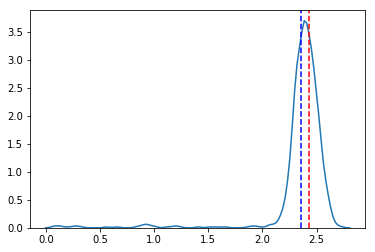

In [167]:
var_id = 7
estimates = qw.sample(1000).eval()[:, var_id]
var_plot = sns.kdeplot(data=estimates)
plt.axvline(x=np.mean(estimates), color = "blue", linestyle="dashed")
plt.axvline(x=reg.coef_.flatten()[var_id], color = "red", linestyle="dashed")
plt.show()

We can, of course reduce this to point estimates, for example by taking the mean or median. Don't forget to evaluate the tensors after sampling to get numpy arrays.

In [168]:
b_est = np.mean(qb.sample(1000).eval())
b_est

-0.06350703

In [169]:
w_est = np.mean(qw.sample(1000).eval(),axis=0)
w_est

array([ 1.566582  ,  3.052825  ,  1.981907  , -0.05523199, -0.4829376 ,
       -0.6071262 ,  1.2385337 ,  2.362202  , -0.10775102, -1.3547199 ,
        0.85287946,  1.4482507 ,  0.5501625 ,  1.8574218 ], dtype=float32)

With point estimates, we can follow the same math as in frequentist logistic regression to calculate probability estimates.

In [50]:
pred = tf.sigmoid(ed.dot(tf.cast(X_test, tf.float32), w_est + b_est)).eval()

In [51]:
pred[0:10]

array([0.26460055, 0.4490029 , 0.5857104 , 0.18223925, 0.18415965,
       0.20116317, 0.66811615, 0.5524457 , 0.7231517 , 0.34375554],
      dtype=float32)

In [52]:
from sklearn.metrics import confusion_matrix, roc_auc_score
print(roc_auc_score(y_test, pred))

0.7924821563653017


To get true Bayesian estimates, we can avoid point estimates and instead sample from the posterior distribution of y. The resulting samples can be used to calculate better measures of our confidence in the prediction.

When predicting on the test data, an issue with Edward that I haven't figured out is that the placeholder for the input data doesn't fit anymore. We defined the placeholder to be the size of the training data for inference, but now need it to be the size of the test data. We therefore copy the posterior with the infered weights and bias distributions and a new placeholder for the test data.

In [170]:
X_post = tf.placeholder(tf.float32, X_test.shape)
y_post = Bernoulli(logits=ed.dot(X_post, qw) + qb)

Sample predictions for all observations from the Bernoulli distribution (i.e. 1/0). Repeat drawing predictions n times to approximate a prediction distribution for each observation. 

In [178]:
yhat = y_post.sample(10000, ).eval({X_post:X_test})
yhat.shape

(10000, 4440)

In [172]:
yhat = np.asarray(yhat)

In [179]:
yhat[0:5,0:2]

array([[0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)

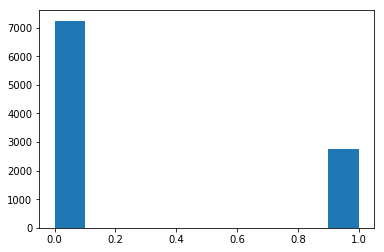

In [180]:
plt.hist(yhat[:,0])
plt.show()

In [175]:
probs = np.mean(yhat, axis = 0)

In [176]:
probs[0:10]

array([0.2536, 0.3775, 0.5253, 0.1368, 0.1352, 0.1718, 0.6441, 0.5136,
       0.7044, 0.3249])

Need to evaluate the tensor. Any tensor is also a numpy array.

In [177]:
from sklearn.metrics import confusion_matrix, roc_auc_score
print(roc_auc_score(y_test, probs))

0.7921850283285391


### Variational inference

In [40]:
#Alternatively, use variational inference.
qw_loc = tf.get_variable("qw_loc", [D])
qw_scale = tf.nn.softplus(tf.get_variable("qw_scale", [D]))
qb_loc = tf.get_variable("qb_loc", []) + 10.0
qb_scale = tf.nn.softplus(tf.get_variable("qb_scale", []))

In [41]:
qw = Normal(loc=qw_loc, scale=qw_scale)
qb = Normal(loc=qb_loc, scale=qb_scale)

In [42]:
#qw_alpha = tf.nn.softplus(tf.get_variable("qw_alpha", [D])) +0.1
#qw_beta = tf.nn.softplus(tf.get_variable("qw_beta", [D]))+0.1
#qb_alpha = tf.nn.softplus(tf.get_variable("qb_alpha", []))+0.1
#qb_beta = tf.nn.softplus(tf.get_variable("qb_beta", []))+0.1

In [43]:
#from edward.models import Beta
#qw = Beta(concentration1=qw_alpha, concentration0=qw_beta)
#qb = Beta(concentration1=qb_alpha, concentration0=qb_beta)

In [44]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})

/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [57]:
inference.run(n_print=10, n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 5696.667


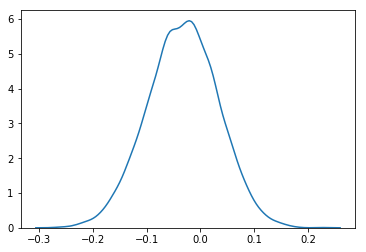

In [55]:
sns.kdeplot(qb.sample(1000).eval())

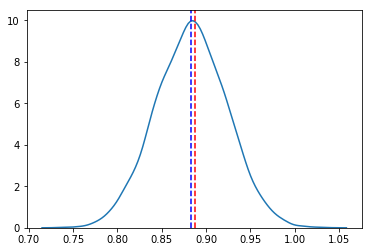

In [67]:
var_id = 10
estimates = qw.sample(10000).eval()[:, var_id]
var_plot = sns.kdeplot(data=estimates)
plt.axvline(x=np.mean(estimates), color = "blue", linestyle="dashed")
plt.axvline(x=reg.coef_.flatten()[var_id], color = "red", linestyle="dashed")
plt.show()

In [20]:
X_post = tf.placeholder(tf.float32, X_test.shape)
y_post = Bernoulli(logits=ed.dot(X_post, qw) + qb)

In [21]:
yhat = y_post.sample(10000, ).eval({X_post:X_test})
yhat.shape

(10000, 4440)

In [22]:
yhat = np.asarray(yhat)

In [23]:
probs = np.mean(yhat, axis = 0)

In [24]:
probs[0:10]

array([0.2681, 0.3497, 0.5102, 0.1112, 0.1565, 0.1655, 0.6702, 0.4915,
       0.7475, 0.357 ])

Need to evaluate the tensor. Any tensor is also a numpy array.

In [25]:
from sklearn.metrics import confusion_matrix, roc_auc_score
print(roc_auc_score(y_test, probs))

0.7915900518198706


### Hamilton Monte Carlo

In [28]:
# INFERENCE
T = 1000 # Number of posterior samples
qw = Empirical(params=tf.get_variable("qw/params", [T, D]))
qb = Empirical(params=tf.get_variable("qb/params", [T]))

In [31]:
inference = ed.HMC({w: qw, b: qb}, data={X: X_train, y: y_train})

/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [36]:
inference.initialize(n_print=10, step_size=0.6)
tf.global_variables_initializer().run()

In [37]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Acceptance Rate: 0.000
